# Summer of Code - Artificial Intelligence

## Week 08: Deep Learning

### Day 05: Training Deep Neural Networks

In this notebook, we will learn the theoretical foundations of **training deep neural networks** using PyTorch.


# The Vanishing and Exploding Gradient Problem

When training deep neural networks, we often encounter the **vanishing and exploding gradient problem**. This occurs when the gradients of the loss function with respect to the weights become very small (vanish) or very large (explode) as they are propagated back through the layers of the network during backpropagation. This can lead to slow convergence or divergence during training.

<img src='sigmoid.png' width='400'>

## Better Weight Initialization
To mitigate the vanishing and exploding gradient problem, we can use better weight initialization techniques. One common approach is to use **Xavier initialization** (also known as Glorot initialization) for layers with sigmoid or tanh activation functions, and **He initialization** for layers with ReLU activation functions.

## Better Activation Functions
Another way to address the vanishing gradient problem is to use activation functions that do not saturate, such as the **ReLU (Rectified Linear Unit)** activation function. ReLU allows gradients to flow more easily through the network, which helps in training deep networks. However, ReLU can suffer from the **dying ReLU** problem, where neurons can become inactive and only output zero. To mitigate this, we can use variants like **Leaky ReLU** or **Parametric ReLU**.

<img src='leaky_relu.png' width='400'>

## Batch Normalization
Another effective technique to combat the vanishing and exploding gradient problem is **Batch Normalization**. This technique normalizes the inputs of each layer to have a mean of zero and a variance of one, which helps stabilize the learning process and allows for higher learning rates.

<img src='b_norm.png' width='700'>

# Reusing Pretrained Layers
In deep learning, it is common to reuse layers from pretrained models. This technique, known as **transfer learning**, allows us to leverage the knowledge learned by a model on a large dataset and apply it to a different but related task. By reusing pretrained layers, we can often achieve better performance with less training data and computational resources.

<img src='pretrained_layers.png' width='500'>


# Dropout
Dropout is a regularization technique used to prevent overfitting in deep neural networks. During training, dropout randomly sets a fraction of the input units to zero at each update step, which helps to break up co-adaptations among neurons. This encourages the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

<img src='dropout.png' width='300'>

# Learning Rate Scheduling
Learning rate scheduling is a technique used to adjust the learning rate during training. By reducing the learning rate as training progresses, we can help the model converge more smoothly and avoid overshooting minima in the loss landscape. Common learning rate scheduling methods include step decay, exponential decay, and cosine annealing.

<img src='lr_schedulers.png' width='500'>

In [1]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load and Prepare CIFAR-10 Dataset
We'll use data augmentation for the training set to improve generalization.

In [2]:
from torchvision import datasets, transforms


transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
        ),
    ]
)

# Only normalization for test
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ]
)


# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(
    root="../../../datasets/data", train=True, download=True, transform=transform_train
)

testset = datasets.CIFAR10(
    root="../../../datasets/data", train=False, download=True, transform=transform_test
)

print(trainset)
print(testset)


Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../../datasets/data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../../../datasets/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [5]:
from torch.utils.data import DataLoader


trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = trainset.classes

print(f"Train batches: {len(trainloader)}, Test batches: {len(testloader)}")
print(classes)

Train batches: 1563, Test batches: 313
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Transfer Learning: Load Pretrained ResNet18
We'll use a pretrained ResNet18 model and fine-tune it for CIFAR-10. We'll:
- Freeze early layers (feature extraction)
- Replace the final layer to match CIFAR-10 classes
- Add dropout for regularization

In [41]:
from torchvision import models

# Load pretrained ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
from torchsummary import summary


summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [28]:
len(list(model.modules()))

68

In [29]:
len(list(model.parameters()))

62

In [ ]:
# Freeze early layers (only fine-tune later layers)
# for param in list(model.parameters())[:-5]:
#     param.requires_grad = False

In [31]:
# list(model.modules())[-1] = nn.Linear(512, 10)

In [32]:
list(model.named_modules())

[('',
  ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [33]:
model.fc.out_features

1000

In [43]:
from torch import nn

# Replace the final fully connected layer with dropout
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.2),  # Dropout for regularization
    nn.Linear(num_features, 10),  # CIFAR-10 has 10 classes
)

model.to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## Setup Training with Learning Rate Scheduler

In [45]:
from torch import nn, optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler: reduce LR by factor of 0.1 every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")

Initial learning rate: 0.001


## Training Loop
Train the model for several epochs, tracking loss and accuracy.

In [46]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total


# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total


print("Training functions defined.")

Training functions defined.


In [47]:
# Train the model
num_epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []
learning_rates = []

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, trainloader, criterion, optimizer, device
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    test_loss, test_acc = validate(model, testloader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Track learning rate
    current_lr = optimizer.param_groups[0]["lr"]
    learning_rates.append(current_lr)

    # Step scheduler
    scheduler.step()

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | "
        f"LR: {current_lr:.6f}"
    )

print("\nTraining completed!")

Starting training...
Epoch 1/10 | Train Loss: 1.1050, Train Acc: 62.83% | Test Loss: 0.7960, Test Acc: 73.42% | LR: 0.001000
Epoch 2/10 | Train Loss: 0.7987, Train Acc: 73.62% | Test Loss: 0.7561, Test Acc: 74.35% | LR: 0.001000
Epoch 3/10 | Train Loss: 0.6861, Train Acc: 76.89% | Test Loss: 0.6104, Test Acc: 79.21% | LR: 0.001000
Epoch 4/10 | Train Loss: 0.5987, Train Acc: 80.24% | Test Loss: 0.7107, Test Acc: 76.39% | LR: 0.001000
Epoch 5/10 | Train Loss: 0.5597, Train Acc: 81.27% | Test Loss: 0.6053, Test Acc: 79.36% | LR: 0.001000
Epoch 6/10 | Train Loss: 0.3625, Train Acc: 87.98% | Test Loss: 0.4828, Test Acc: 83.75% | LR: 0.000100
Epoch 7/10 | Train Loss: 0.2985, Train Acc: 89.90% | Test Loss: 0.4736, Test Acc: 84.05% | LR: 0.000100
Epoch 8/10 | Train Loss: 0.2612, Train Acc: 91.24% | Test Loss: 0.4739, Test Acc: 83.97% | LR: 0.000100
Epoch 9/10 | Train Loss: 0.2385, Train Acc: 92.12% | Test Loss: 0.4752, Test Acc: 84.37% | LR: 0.000100
Epoch 10/10 | Train Loss: 0.2082, Train Acc

## Visualize Training Progress
Plot the training/test loss, accuracy, and learning rate schedule.

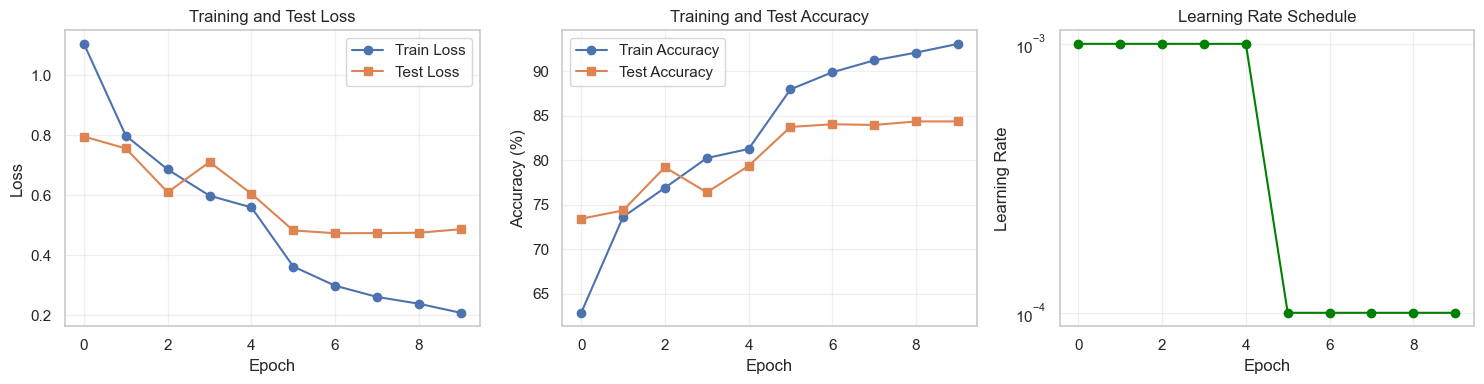


Final Test Accuracy: 84.37%


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Plot training results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(train_losses, label="Train Loss", marker="o")
axes[0].plot(test_losses, label="Test Loss", marker="s")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Test Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accs, label="Train Accuracy", marker="o")
axes[1].plot(test_accs, label="Test Accuracy", marker="s")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Training and Test Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate schedule
axes[2].plot(learning_rates, marker="o", color="green")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].set_yscale("log")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {test_accs[-1]:.2f}%")